In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from jaqalpaq import run
from jaqalpaq import emulator
from jaqalpaq.run import run_jaqal_file, run_jaqal_string, run_jaqal_batch, run_jaqal_circuit, frontend
# from jaqalpaq.run import * (identical to from jaqalpaq import run aside from needing "run" before everything)
# from jaqalpaq.run import frontend (needed to switch between emulator and experiment)
from jaqalpaq.parser import parse_jaqal_string

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["g", "orange", "darkred", "b"])#, "khaki", "hotpink", "teal", "mediumorchid"]) 


In [2]:
num_qubits = 2
num_states = 1<<num_qubits

### Batching with Override Dictionary

In [3]:
#Create a jaqal code (string method)

jaqal_code = f"""
//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1701
let beta 0.1701
let gamma 0.72405
let delta 0.74656
let epsilon 0.01
let zeta 0.1031
let eta 0.82893
let theta 0.75567
let iota 0.76884
let kappa 0.1701

let num_loops 0
let pi_4 {np.pi/4}

//Select your register of qubits
register q[{num_qubits}]

//Create jaqal circuit, starting with prepare_all, ending with measure_all
prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>
MS q[0] q[1] eta theta
R q[0] iota kappa
loop num_loops {{
    MS q[0] q[1] 0 pi_4}}
measure_all
"""

In [4]:
#Define series of arrays for an 'override' dictionary
angles = list(np.linspace(-np.pi/2,np.pi/2, 21))
thetas = [np.pi/2-abs(a) for a in angles]
loops = list(range(0,21))

#Define a python dictionary to be the override dictionary
#We can override any and/or all let parameters. Caveat: All elements of the dictionary must be the same length array OR a scalar
override_dict={ "alpha":   angles,
                "beta":    angles,
                "gamma":   angles,
                "delta":   angles,
                "epsilon": angles,
                "zeta":    angles,
                "eta":     angles,
                "theta":   thetas,
                "iota":    angles,
                "kappa":   angles,
                "num_loops": loops,
                "__repeats__": 2000}

#Run the circuit with the parameters being overwritten
res = run_jaqal_string(jaqal_code, overrides=override_dict)

#The result object that is returned has quite a lot of information stored in it.
#This object contains the data sorted by each instance of the override dictionary, known as a subbatch
#This subbatch is then further divided into subcircuits (if we had any). If not, just use .by_subcircuit[0]
#We can then call for the probability sorted by the integer of the binary representation of the qubit states
print("PROBABILITIES ORDERED BY QUBIT INTEGER VALUE")
for i in range(len(angles)):
    print(res.by_subbatch[i].by_subcircuit[0].simulated_probabilities.by_int_dense) #absolute probability
    print(res.by_subbatch[i].by_subcircuit[0].normalized_counts.by_int_dense) #with simulated shot noise
    
#We can also sort the resulting probabilities by their string representation (matrix/ket ordering)
print("PROBABILITIES ORDERED BY QUBIT STRING REPRESENTATION")
for i in range(len(angles)):
    print(res.by_subbatch[i].by_subcircuit[0].simulated_probabilities.by_str_dense) #absolute probability
    print(res.by_subbatch[i].by_subcircuit[0].normalized_counts.by_str_dense) #with simulated shot noise

PROBABILITIES ORDERED BY QUBIT INTEGER VALUE
[[0.25]
 [0.25]
 [0.25]
 [0.25]]
[[0.2505]
 [0.2485]
 [0.239 ]
 [0.262 ]]
[[0.15521143]
 [0.29205858]
 [0.21796375]
 [0.33476625]]
[[0.1515]
 [0.311 ]
 [0.214 ]
 [0.3235]]
[[0.0219206 ]
 [0.20659587]
 [0.32183631]
 [0.44964721]]
[[0.0245]
 [0.2075]
 [0.3285]
 [0.4395]]
[[0.00710145]
 [0.11161837]
 [0.42340979]
 [0.45787039]]
[[0.0125]
 [0.1205]
 [0.4155]
 [0.4515]]
[[0.01493425]
 [0.15583128]
 [0.35569488]
 [0.47353959]]
[[0.018 ]
 [0.1565]
 [0.3545]
 [0.471 ]]
[[0.05334709]
 [0.26830583]
 [0.17991748]
 [0.49842961]]
[[0.0555]
 [0.2805]
 [0.1845]
 [0.4795]]
[[0.31000929]
 [0.28146769]
 [0.06684163]
 [0.3416814 ]]
[[0.312]
 [0.283]
 [0.068]
 [0.337]]
[[0.63382386]
 [0.17508098]
 [0.05305083]
 [0.13804433]]
[[0.6645]
 [0.151 ]
 [0.046 ]
 [0.1385]]
[[0.59949211]
 [0.06079955]
 [0.05226754]
 [0.28744081]]
[[0.601 ]
 [0.0555]
 [0.047 ]
 [0.2965]]
[[0.22137474]
 [0.00899478]
 [0.02118271]
 [0.74844777]]
[[0.2275]
 [0.011 ]
 [0.021 ]
 [0.7405]]
[[0

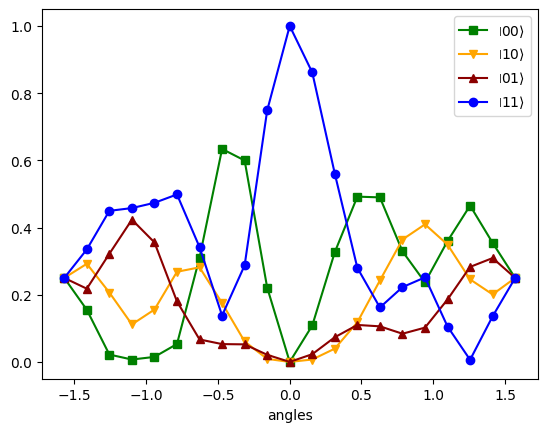

In [5]:
#Plot the results
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch:
    for n in range(num_states):
        outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])

plt.figure(1)        
for n in range(num_states):
    plt.plot(angles, 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("angles");

### Batching with Subcircuits

In [6]:
#Define some functions to do Pauli twirling about the MS gate

def random_gate_insert():
    gates_added = [[], []]
    for qubit in range(2): #For each qubit in the circuit
        twirling_gate = np.random.choice(['I', 'Px', 'Py', 'Pz'])
        if twirling_gate != 'I':
            gates_added[qubit] += [twirling_gate]
    return gates_added

def inverse_gate_insert(gates_added):
    inverse_added = [[], []]
    for qubit in range(2):
        if gates_added[qubit] == ['Px']:
            inverse_added[qubit] += ['Px']
                
        elif gates_added[qubit] == ['Py']:
            inverse_added[qubit] += ['Pz']
            inverse_added[(qubit+1)%2] += ['Px']
            
        elif gates_added[qubit] == ['Pz']:
            inverse_added[qubit] += ['Py']
            inverse_added[(qubit+1)%2] += ['Px']
    return inverse_added

def two_pauli_multiplication(pauli1, pauli2):
    new_pauli = ''
    if ((pauli1 == 'Px') & (pauli2 == 'Py')) | ((pauli1 == 'Py') & (pauli2 == 'Px')):
        new_pauli = 'Pz'
    elif ((pauli1 == 'Px') & (pauli2 == 'Pz')) | ((pauli1 == 'Pz') & (pauli2 == 'Px')):
        new_pauli = 'Py'
    elif ((pauli1 == 'Pz') & (pauli2 == 'Py')) | ((pauli1 == 'Py') & (pauli2 == 'Pz')):
        new_pauli = 'Px'
    return new_pauli

def pauli_compile(inverse_added, gates_added):
    gate_string = ""
    for index in range(2):
        equivalent_pauli = '' #No gates
        if len(inverse_added[index]) == 2: #Two gates
            equivalent_pauli = two_pauli_multiplication(inverse_added[index][0], inverse_added[index][1])
        elif len(inverse_added[index]) == 1: #One gate
            equivalent_pauli = inverse_added[index][0]
        if gates_added[index] != []:
            if equivalent_pauli != '': #Combine gates before and after
                equivalent_pauli = two_pauli_multiplication(equivalent_pauli, gates_added[index][0])
            else:
                equivalent_pauli = gates_added[index][0]
        if equivalent_pauli != '':
            gate = "\n"+ equivalent_pauli + f" q[{index}]"
            gate_string += gate
    return gate_string

In [7]:
#Create the elements of the jaqal file

jaqal_header = f"""
//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1701
let beta 0.1701
let gamma 0.72405
let delta 0.74656
let epsilon 0.01
let zeta 0.1031
let eta 0.82893
let theta 0.75567
let iota 0.76884
let kappa 0.1701

let num_loops 0
let pi_4 {np.pi/4}
let pi_2 {np.pi/2}

//Select your register of qubits
register q[{num_qubits}]"""

jaqal_prep = """
prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>"""

jaqal_MS = """
MS q[0] q[1] 0 pi_2"""

jaqal_measure = """
R q[0] iota kappa
measure_all"""


In [8]:
#Create the jaqal file with the Pauli twirls

jaqal_code = jaqal_header 
num_RC = 10

for n in range(num_RC):    
    gates_added = [[], []]
    inverse_added = [[], []]
    jaqal_code += jaqal_prep
    gates_added = random_gate_insert()
    jaqal_code += pauli_compile(inverse_added, gates_added)
    jaqal_code += jaqal_MS
    inverse_added = inverse_gate_insert(gates_added)
    jaqal_code += pauli_compile(inverse_added, [[], []])
    jaqal_code += jaqal_measure
    jaqal_code += "\n"
    
print(jaqal_code)
  


//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1701
let beta 0.1701
let gamma 0.72405
let delta 0.74656
let epsilon 0.01
let zeta 0.1031
let eta 0.82893
let theta 0.75567
let iota 0.76884
let kappa 0.1701

let num_loops 0
let pi_4 0.7853981633974483
let pi_2 1.5707963267948966

//Select your register of qubits
register q[2]
prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>
Pz q[0]
Px q[1]
MS q[0] q[1] 0 pi_2
Py q[0]
R q[0] iota kappa
measure_all

prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>
Pz q[1]
MS q[0] q[1] 0 pi_2
Px q[0]
Py q[1]
R q[0] iota kappa
measure_all

prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon | Rz q[1] zeta>
Py q[0]
Py q[1]
MS q[0] q[1] 0 pi_2
Py q[0]
Py q[1]
R q[0] iota kappa
measure_all

prepare_all
<R q[0] alpha beta | R q[1] gamma delta>
<Rz q[0] epsilon

In [9]:
#Running the string

res = run_jaqal_string(jaqal_code, overrides = {"__repeats__": 200})

#The result object that is returned has quite a lot of information stored in it.
#In this case we have a single subbatch, since we're not providing an override dictionary (aside from the number of shots)
#This subbatch is then further divided into our 10 subcircuits.
#We can then call for the probability sorted by the integer of the binary representation of the qubit states
print("PROBABILITIES ORDERED BY QUBIT INTEGER VALUE")
for i in range(num_RC):
    print(res.by_subbatch[0].by_subcircuit[i].simulated_probabilities.by_int_dense) #absolute probability
    print(res.by_subbatch[0].by_subcircuit[i].normalized_counts.by_int_dense) #with simulated shot noise
    
#We can also sort the resulting probabilities by their string representation (matrix/ket ordering)
print("PROBABILITIES ORDERED BY QUBIT STRING REPRESENTATION")
for i in range(num_RC):
    print(res.by_subbatch[0].by_subcircuit[i].simulated_probabilities.by_str_dense) #absolute probability
    print(res.by_subbatch[0].by_subcircuit[i].normalized_counts.by_str_dense) #with simulated shot noise

PROBABILITIES ORDERED BY QUBIT INTEGER VALUE
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.46 ]
 [0.095]
 [0.015]
 [0.43 ]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.405]
 [0.09 ]
 [0.05 ]
 [0.455]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.42 ]
 [0.055]
 [0.04 ]
 [0.485]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.4  ]
 [0.135]
 [0.045]
 [0.42 ]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.405]
 [0.115]
 [0.01 ]
 [0.47 ]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.355]
 [0.09 ]
 [0.05 ]
 [0.505]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.455]
 [0.08 ]
 [0.02 ]
 [0.445]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.425]
 [0.09 ]
 [0.025]
 [0.46 ]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.36 ]
 [0.11 ]
 [0.045]
 [0.485]]
[[0.39818686]
 [0.09484271]
 [0.02904003]
 [0.47793041]]
[[0.405]
 [0.075]
 [0.045]
 [0.475]]
PROBABILITIES O

Text(0.5, 0, 'RC index')

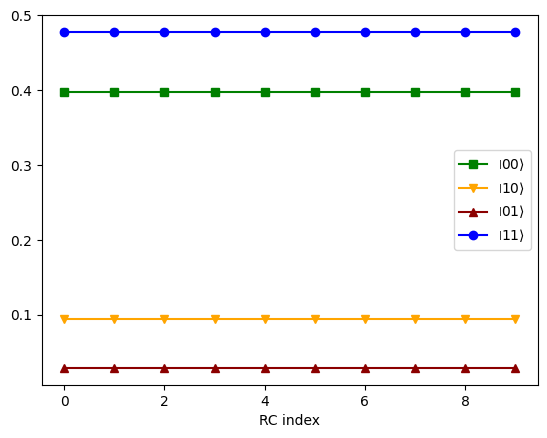

In [10]:
plt.figure(2)
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch[0].by_subcircuit:
    for n in range(num_states):
        outcomes[n].append(r.simulated_probabilities.by_int[n])
for n in range(num_states):
    plt.plot(range(num_RC),
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("RC index")

### Batching with Indexing

In [11]:
#Nominally, the circuits are run in the order presented in the jaqal file, but if we wanted to run them in some other order we can do indexing

#For simplicity we will define another series of jaqal_code subcircuits


jaqal_code = f"""
from qscout.v1.std usepulses *

let pi_2 {np.pi/2}
let pi_4 {np.pi/4}
let theta 0

register q[{num_qubits}]

prepare_all
MS q[0] q[1] 0 pi_2
Rz q[0] pi_2
measure_all

prepare_all
MS q[0] q[1] 0 pi_2
Rz q[0] pi_2
<Sx q[0] | Sx q[1]>
measure_all

prepare_all
MS q[0] q[1] 0 pi_2
Rz q[0] pi_2
<Sy q[0] | Sy q[1]>
measure_all

prepare_all
MS q[0] q[1] pi_2 pi_2
Rz q[0] pi_2
measure_all

prepare_all
MS q[0] q[1] pi_2 pi_2
Rz q[0] pi_2
<Sx q[0] | Sx q[1]>
measure_all

prepare_all
MS q[0] q[1] pi_2 pi_2
Rz q[0] pi_2
<Sy q[0] | Sy q[1]>
measure_all
"""

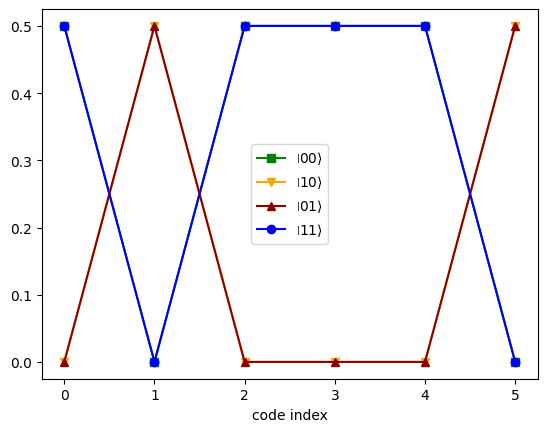

In [12]:
#Running it via standard subcircuit ordering

outcomes = [[] for _ in range(num_states)]

res = run_jaqal_string(jaqal_code, overrides = {"__repeats__": 200})

#Plot the results
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch[0].by_subcircuit:
    for n in range(num_states):
        outcomes[n].append(r.simulated_probabilities.by_int[n])

plt.figure(1)        
for n in range(num_states):
    plt.plot([0,1,2,3,4,5], 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("code index");

PROBABILITIES ORDERED BY QUBIT INTEGER VALUE
[[0.5]
 [0. ]
 [0. ]
 [0.5]]
[[0.475]
 [0.   ]
 [0.   ]
 [0.525]]
[[0. ]
 [0.5]
 [0.5]
 [0. ]]
[[0.   ]
 [0.495]
 [0.505]
 [0.   ]]
[[0.5]
 [0. ]
 [0. ]
 [0.5]]
[[0.475]
 [0.   ]
 [0.   ]
 [0.525]]
[[0.5]
 [0. ]
 [0. ]
 [0.5]]
[[0.535]
 [0.   ]
 [0.   ]
 [0.465]]
[[0.5]
 [0. ]
 [0. ]
 [0.5]]
[[0.475]
 [0.   ]
 [0.   ]
 [0.525]]
[[0. ]
 [0.5]
 [0.5]
 [0. ]]
[[0.  ]
 [0.51]
 [0.49]
 [0.  ]]
PROBABILITIES ORDERED BY QUBIT STRING REPRESENTATION
{'00': array([0.5]), '10': array([0.]), '01': array([0.]), '11': array([0.5])}
{'00': array([0.475]), '10': array([0.]), '01': array([0.]), '11': array([0.525])}
{'00': array([0.]), '10': array([0.5]), '01': array([0.5]), '11': array([0.])}
{'00': array([0.]), '10': array([0.495]), '01': array([0.505]), '11': array([0.])}
{'00': array([0.5]), '10': array([0.]), '01': array([0.]), '11': array([0.5])}
{'00': array([0.475]), '10': array([0.]), '01': array([0.]), '11': array([0.525])}
{'00': array([0.5]), '10

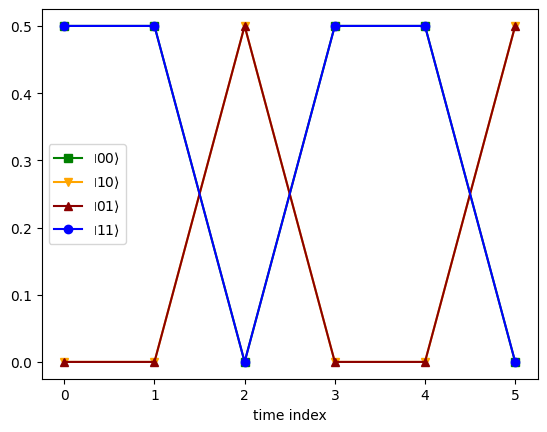

In [13]:
# We can also run this by indexing different codes, so if we wanted all Z, X, or Y projections grouped together
indices = 6
res = run_jaqal_string(jaqal_code, overrides = {"__index__": [[0,3,1,4,2,5]],
                                                "__repeats__": 200})
#Note that the indexes are contained within a nested list!


print("PROBABILITIES ORDERED BY QUBIT INTEGER VALUE")
for i in range(indices):
    print(res.by_subbatch[0].by_subcircuit[i].simulated_probabilities.by_int_dense) #absolute probability
    print(res.by_subbatch[0].by_subcircuit[i].normalized_counts.by_int_dense) #with simulated shot noise
    
#We can also sort the resulting probabilities by their string representation (matrix/ket ordering)
print("PROBABILITIES ORDERED BY QUBIT STRING REPRESENTATION")
for i in range(indices):
    print(res.by_subbatch[0].by_subcircuit[i].simulated_probabilities.by_str_dense) #absolute probability
    print(res.by_subbatch[0].by_subcircuit[i].normalized_counts.by_str_dense) #with simulated shot noise

#Note, these are still plotting based on subcircuit number! But if we want to see how it was actually performed in time
# on the experiment or the emulator, we can use the by_time command:

print("RESULTS ORDERED BY TIME")
for i in range(indices):
    print(res.by_time[i].simulated_probabilities.by_int_dense) #absolute probability
    print(res.by_time[i].normalized_counts.by_int_dense) #with simulated shot noise
    
#Plot the results by time
outcomes = [[] for _ in range(num_states)]
for r in res.by_time:
    for n in range(num_states):
        outcomes[n].append(r.simulated_probabilities.by_int[n])

plt.figure(1)        
for n in range(num_states):
    plt.plot([0,1,2,3,4,5], 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:02b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
plt.legend()
plt.xlabel("time index");

### Putting it all together